In [1]:
%pip install -q requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt


### 1. Import Dependencies


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

### 2. Load and Exploring data

In [3]:
df = pd.read_csv('data/processed/ChurnModelling_Binnig_Applied.csv')
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditSCoreBins
0,France,Female,42.00,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,42.00,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,38.91,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0,Excellent


### 3. Build Scikit-learn Pipeline

In [8]:
numerical_features = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
norminal_features = ['Gender', 'Geography']
ordinal_features = ['CreditSCoreBins']
remainder_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']



numerical_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', StandardScaler())
                                ]
                                )

norminal_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(
                                                            strategy='constant',
                                                            fill_value='missing'
                                                            )),
                                    ('encoder', OneHotEncoder())
                                ]
                                )

ordinal_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(
                                                            strategy='constant',
                                                            fill_value='missing'
                                                            )),
                                    ('encoder', OrdinalEncoder())
                                ]
                                )

preprocessor = ColumnTransformer(
                                transformers=[
                                            ('num', numerical_transformer, numerical_features),
                                            ('nom', norminal_transformer, norminal_features),
                                            ('ord', ordinal_transformer, ordinal_features)
                                ],
                                remainder='drop'
                                )

norminal_feature_names = []
for feature in norminal_features:
    unique_values = df[feature].unique()
    norminal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

df_cp = df.copy()
df_transformed = pd.DataFrame(
                            preprocessor.fit_transform(df_cp),
                            columns=numerical_features+norminal_feature_names+ordinal_features
                            )
df_remainder = df[remainder_features]
df_pp = pd.concat(
                [df_transformed, df_remainder], 
                axis=1
                )

In [11]:
df_pp.to_csv('data/processed/X_Tranformed.csv')

### 4. Handle Class Imbalance

In [12]:
X = df_pp.drop(columns=['Exited'])
Y = df_pp['Exited']

In [14]:
"""
chrun - 1000
non-churn - 9000

upsample - (chrun) 1000 -> 9000
downsamping - (non-churn) 9000 -> 1000
"""

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )



In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

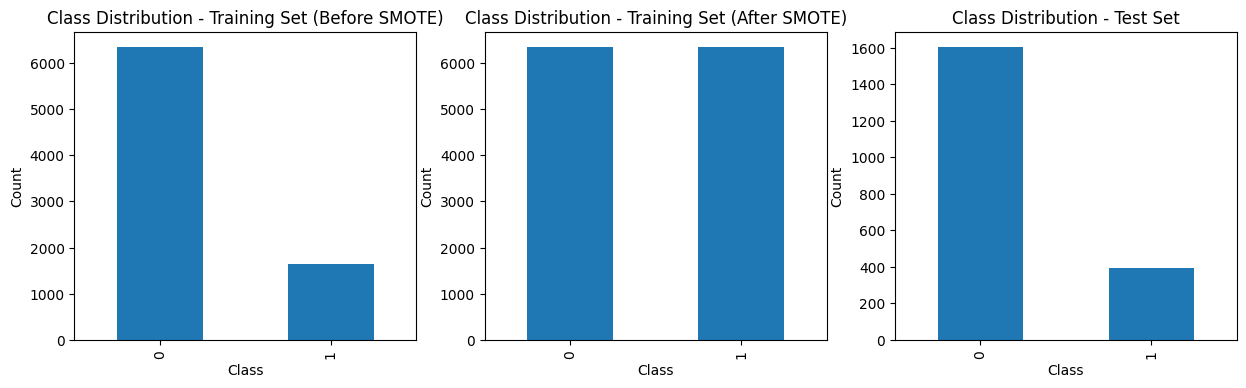

In [16]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

In [17]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', Y_test)